In [1]:
from grad_cam import GradCAM
from utils.image import show_cam_on_image, preprocess_image
from utils.model_targets import ClassifierOutputTarget

from utils.RCFT_img_load import load_img
from model import resnet

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import cv2
import pickle
from PIL import Image
import requests
import torch
from torchinfo import summary

## 1. ImageNet 예시

### pre-trained model load ###

In [3]:
model = resnet.resnet50(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
summary(model,input_size=(16,3,512,512))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 1000]                --
├─Conv2d: 1-1                            [16, 64, 256, 256]        9,408
├─BatchNorm2d: 1-2                       [16, 64, 256, 256]        128
├─ReLU: 1-3                              [16, 64, 256, 256]        --
├─MaxPool2d: 1-4                         [16, 64, 128, 128]        --
├─Sequential: 1-5                        [16, 256, 128, 128]       --
│    └─Bottleneck: 2-1                   [16, 256, 128, 128]       --
│    │    └─Conv2d: 3-1                  [16, 64, 128, 128]        4,096
│    │    └─BatchNorm2d: 3-2             [16, 64, 128, 128]        128
│    │    └─ReLU: 3-3                    [16, 64, 128, 128]        --
│    │    └─Conv2d: 3-4                  [16, 64, 128, 128]        36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 128, 128]        128
│    │    └─ReLU: 3-6                    [16, 64, 128, 128]        --
│ 

### 예시 이미지 ###

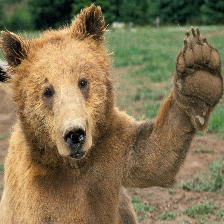

In [5]:
image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
orig_img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(orig_img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Image.fromarray(cv2.resize(orig_img, (224, 224)))

### Grad Cam ###

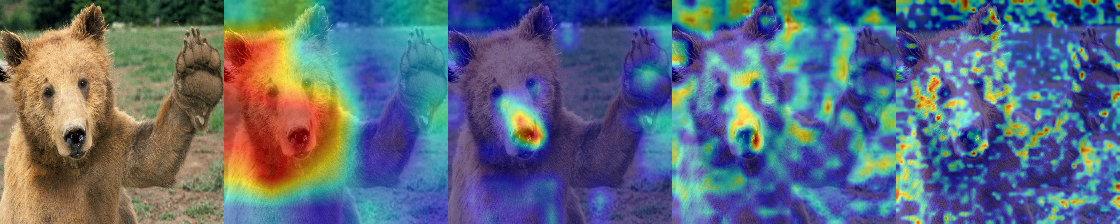

In [6]:
# 1000개 class 중 295는 'American black bear, black bear, Ursus americanus, Euarctos americanus'를 의미
targets = [ClassifierOutputTarget(295)]

with GradCAM(model=model, target_layers=[model.layer4], use_cuda=True) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image4 = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

with GradCAM(model=model, target_layers=[model.layer3], use_cuda=True) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image3 = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
    
with GradCAM(model=model, target_layers=[model.layer2], use_cuda=True) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image2 = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

with GradCAM(model=model, target_layers=[model.layer1], use_cuda=True) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image1 = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
    
images = np.hstack((np.uint8(255*img), cam_image4, cam_image3, cam_image2, cam_image1))
Image.fromarray(images)

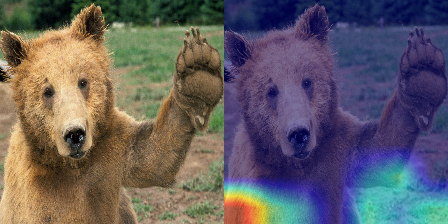

In [7]:
# 해당 이미지와 맞지 않는 target의 weight를 사용한 경우
# 1000개 class 중 587 'hammer'를 의미
targets = [ClassifierOutputTarget(587)]

with GradCAM(model=model, target_layers=[model.layer4], use_cuda=True) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image4 = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
    
images = np.hstack((np.uint8(255*img), cam_image4))
Image.fromarray(images)

## 2. RCFT 예제

### pre-trained model load

In [8]:
from model.RCFT_model import Model
import argparse

In [9]:
parser = argparse.ArgumentParser()
parser.add_argument('--model_name', type=str, default='resnet50')
parser.add_argument('--l2_norm', type=float, default=1e-5)
parser.add_argument('--l1_norm', type=float, default=1e-5)
config = parser.parse_args(args=[])

In [10]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Model(config=config, model_path='./')
model = model.load_from_checkpoint('model-epoch=19-val_acc=0.893-val_sen=0.846154-val_spe=0.933333-val_avg_loss=0.2949.ckpt', config=config, model_path='./')
model.eval()

Model(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

### RCFT 이미지 load ###

In [16]:
from glob import glob

imgs=glob('./toys/*.jpg')

cn_img = np.array(Image.open(imgs[1]))
ad_img = np.array(Image.open(imgs[0]))

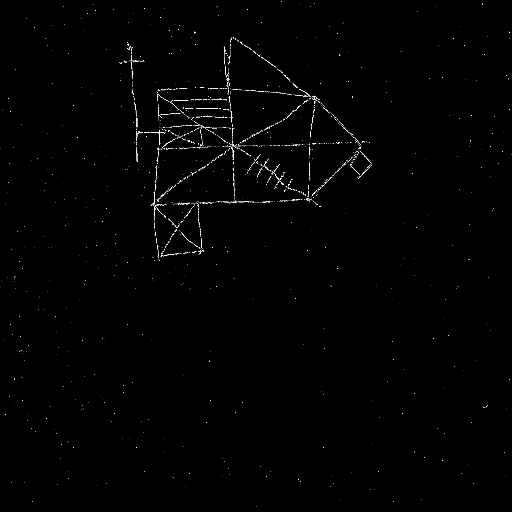

In [17]:
# cn
Image.fromarray(cv2.resize(cn_img,(512,512)))

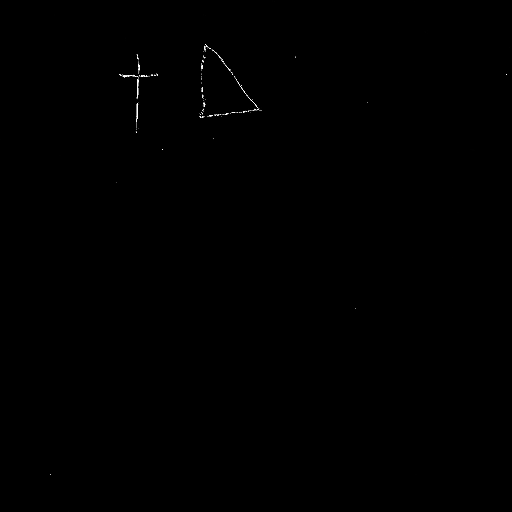

In [18]:
# ad
Image.fromarray(cv2.resize(ad_img,(512,512)))

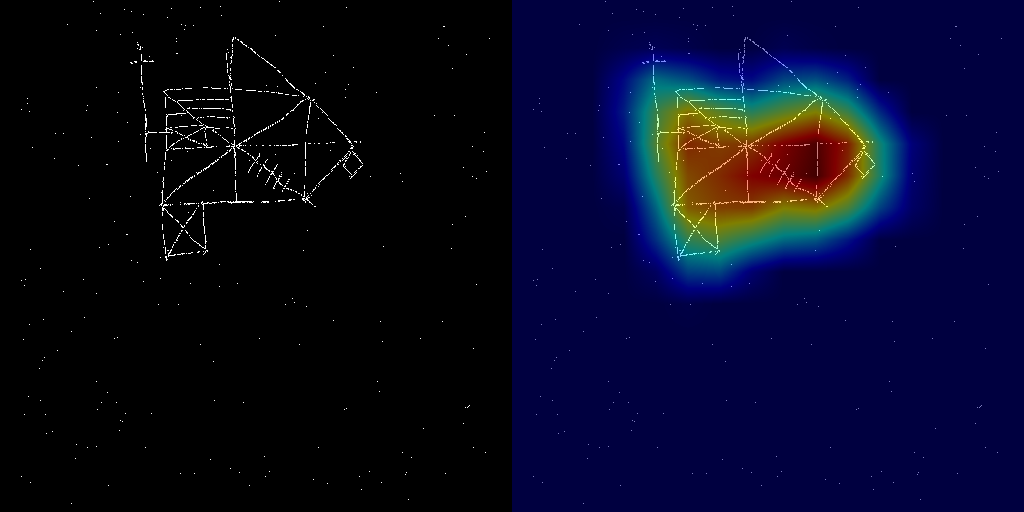

In [22]:
img = load_img(imgs[1], 512)
img_tensor = torch.tensor(img, device=gpu).float()
img_tensor = img_tensor.unsqueeze(0)

# cn : target 0 
targets = [ClassifierOutputTarget(0)]
target_layers = [model.net.layer4]

with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
    grayscale_cams = cam(input_tensor=img_tensor, targets=targets)
    cam_image = show_cam_on_image(np.moveaxis(img,0,-1), grayscale_cams[0, :], use_rgb=True)

images = np.hstack((np.uint8(255*np.moveaxis(img,0,-1)), cam_image))
Image.fromarray(images)

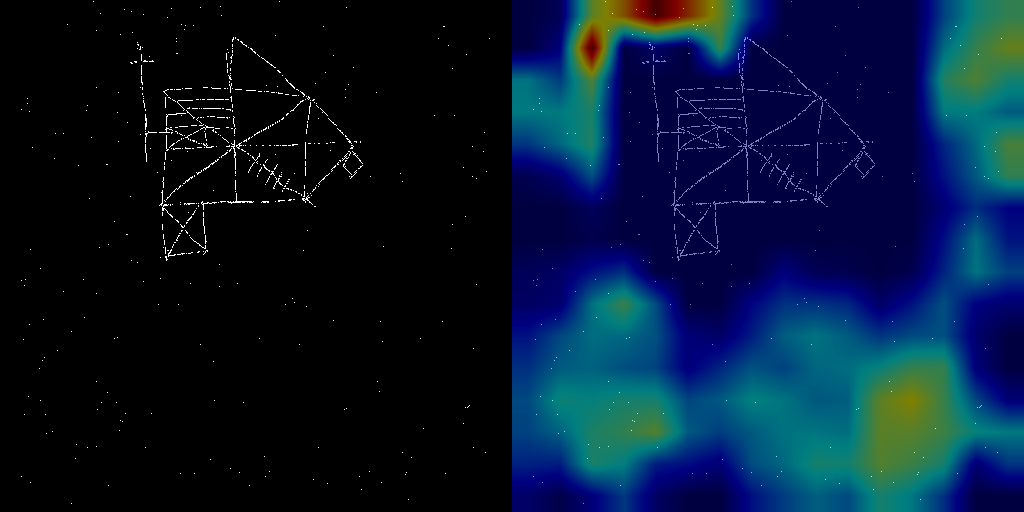

In [24]:
img = load_img(imgs[1], 512)
img_tensor = torch.tensor(img, device=gpu).float()
img_tensor = img_tensor.unsqueeze(0)

# target을 1로 본다면
targets = [ClassifierOutputTarget(1)]
target_layers = [model.net.layer4]

with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
    grayscale_cams = cam(input_tensor=img_tensor, targets=targets)
    cam_image = show_cam_on_image(np.moveaxis(img,0,-1), grayscale_cams[0, :], use_rgb=True)

images = np.hstack((np.uint8(255*np.moveaxis(img,0,-1)), cam_image))
Image.fromarray(images)

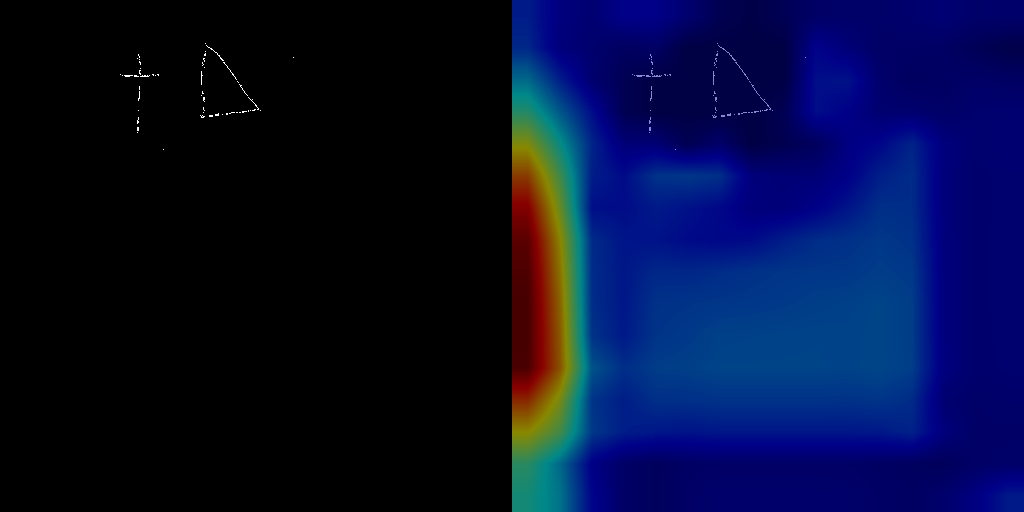

In [25]:
img = load_img(imgs[0], 512)
img_tensor = torch.tensor(img, device=gpu).float()
img_tensor = img_tensor.unsqueeze(0)

# ad : target 1
targets = [ClassifierOutputTarget(1)]
target_layers = [model.net.layer4]

with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
    grayscale_cams = cam(input_tensor=img_tensor, targets=targets)
    cam_image = show_cam_on_image(np.moveaxis(img,0,-1), grayscale_cams[0, :], use_rgb=True)

images = np.hstack((np.uint8(255*np.moveaxis(img,0,-1)), cam_image))
Image.fromarray(images)

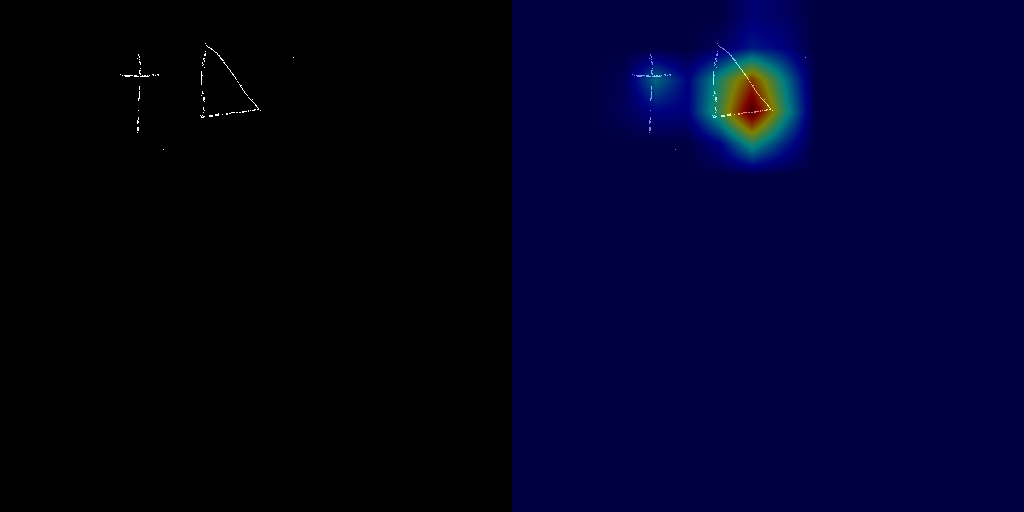

In [26]:
img = load_img(imgs[0], 512)
img_tensor = torch.tensor(img, device=gpu).float()
img_tensor = img_tensor.unsqueeze(0)

# target을 0으로 본다면
targets = [ClassifierOutputTarget(0)]
target_layers = [model.net.layer4]

with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
    grayscale_cams = cam(input_tensor=img_tensor, targets=targets)
    cam_image = show_cam_on_image(np.moveaxis(img,0,-1), grayscale_cams[0, :], use_rgb=True)

images = np.hstack((np.uint8(255*np.moveaxis(img,0,-1)), cam_image))
Image.fromarray(images)